# PLAN

0. [x] Get the data.
0. [x] Prepare the data for exploration.
0. [x] Split the data into train and test sets.
0. [x] Explore the data.
0. [ ] Do cross-validation with the data.
0. [ ] Code and evaluate several models.
0. [ ] Evaluate out of sample data (test set).

In [1]:
import os
import acquire
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from functools import reduce

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree

import acquire
import prepare
from prepare import rename_columns
from prepare import replace_nonvals
from prepare import value_counts

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [3]:
from env import path

# ACQUISITION

In [4]:
df1 = acquire.read_data('data01.csv')
df2 = acquire.read_data('data02.csv')
df3 = acquire.read_data('data03.csv')
df4 = acquire.read_data('data04.csv')
df5 = acquire.read_data('data05.csv')
df7 = acquire.read_data('data07.csv')

In [5]:
# dfs = [df1, df2, df3]

In [6]:
df1.head()

,CASEID,INVIEWN,B1AGE,AGER,AGERR,B2EDU,HIGHSCHL,B3EMPLY1,B3EMPLY2,B3EMPLY3,...,NAWYEAR,RELAC1,LENGTHC1,C1SITUAT,PARTNERS,PABUSE,SPANISH1,INMONTH,INYEAR,INDAY
0,108395,1,18,1,1,3,0,2,9999,9999,...,99,6,1,1,1,1,2,1,1998,27
1,108397,1,30,3,2,7,1,3,9999,9999,...,99,5,2,1,1,1,2,1,1998,27
2,108399,1,27,3,1,3,0,9,9999,9999,...,99,5,5,1,1,1,2,1,1998,30
3,108443,1,19,1,1,3,0,7,9999,9999,...,99,5,2,1,1,1,2,2,1998,9
4,108444,1,18,1,1,3,0,9,9999,9999,...,99,6,2,1,1,1,2,2,1998,9


In [7]:
# Specify columns to take from dataframes 1, 2, 3, 4, 5, and 7:


one_cols = ['CASEID',
            'ABUSED',
            'SCRSTATR',
            'LENGTHC1',
            'C1SITUAT',
            'PABUSE',
             ]


two_cols = ['CASEID',
            'D3RCHILT',
           ]

three_cols = ['CASEID',
              'E13PRGNT',
              'N7PREGNT',
              'TOTSUPRT'
             ]

four_cols = ['CASEID',
             'G1NUMBER', 
             'H1JEALUS', 
             'H2LIMIT',
             'H3KNOWNG',
             'J1HIT',
             'J2THROWN',
             'J3PUSH',
             'J4SLAP',
             'J5KICK',
             'J6OBJECT',
             'J7BEAT',
             'J8CHOKE',
             'J9KNIFE',
             'J10GUN',
             'J11SEX',
             'POWER',
             'HARASS',
            ]

five_cols = ['CASEID', 
             'B1AGE',
             'AGEDISP',
             'STDETAI',
            ]

seven_cols = ['CASEID',
              'SAMESEXR',
              'N11DRUGS',
              'N12ALCHL',
              'N13SUHIM',
              'N16CHILD',
              'N17ARRST',
              'N1FRQNCY',
              'N2SVRITY',
              'N3WEAPON',
              'N4CHOKE',
              'N5SEX',
              'N6CONTRL',
              'N8JEALUS',
              'N10CPBLE',
             ]

In [8]:
# drop dataframes down to desired features
df1 = df1[one_cols]
df2 = df2[two_cols]
df3 = df3[three_cols]
df4 = df4[four_cols]
df5 = df5[five_cols]
df7 = df7[seven_cols]

In [9]:
print(df1.shape)
print(df2.shape)
print(df3.shape)
print(df4.shape)
print(df5.shape)
print(df7.shape)

(705, 6)
(705, 2)
(705, 4)
(705, 18)
(705, 4)
(705, 15)


In [10]:
dfa = df1.merge(right=df2, on='CASEID')
dfa = dfa.merge(right=df3, on='CASEID')
dfa = dfa.merge(right=df4, on='CASEID')
dfa = dfa.merge(right=df5, on='CASEID')
dfa = dfa.merge(right=df7, on='CASEID')

In [11]:
dfa.shape

(705, 44)

## dfa: this is the dataframe with the NAW (Not Abused Woman) & AW (Abused Woman) cases.

In [12]:
# look at unaltered value counts
prepare.value_counts(dfa)

CASEID

-------------------------------------------------------------

ABUSED
1    497
2    208
Name: ABUSED, dtype: int64

-------------------------------------------------------------

SCRSTATR
1      455
2      118
3      115
999     17
Name: SCRSTATR, dtype: int64

-------------------------------------------------------------

LENGTHC1
1    159
2    153
3     83
4    105
5    147
6     58
Name: LENGTHC1, dtype: int64

-------------------------------------------------------------

C1SITUAT
1    395
2     18
3     74
4     10
9    208
Name: C1SITUAT, dtype: int64

-------------------------------------------------------------

PABUSE
1    464
2     27
3      6
9    208
Name: PABUSE, dtype: int64

-------------------------------------------------------------

D3RCHILT
0      339
1      136
2      113
3       57
4       32
5        9
6        9
7        5
12       1
555      1
666      1
999      2
Name: D3RCHILT, dtype: int64

-----------------------------------------------------------

In [13]:
# change dfa to df to match conventions of prepare.py
df = dfa
# get repeated cases applied as a column
df['RECID'] = df.CASEID.apply(prepare.get_repeat_case)
#use prepare function to rename features 
prepare.rename_columns(df)

In [14]:
# ensure renaming of features worked
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 705 entries, 0 to 704
Data columns (total 45 columns):
id                              705 non-null int64
abuse_past_year                 705 non-null int64
abuse_status                    705 non-null int64
length_relationship             705 non-null int64
partner_abusive                 705 non-null int64
num_abusers                     705 non-null int64
num_children                    705 non-null int64
pregnant                        705 non-null int64
beaten_while_pregnant           705 non-null int64
support_score                   705 non-null int64
guns_in_home                    705 non-null int64
jealous_past_year               705 non-null int64
limit_family_contact            705 non-null int64
location_tracking               705 non-null int64
threat_hit                      705 non-null int64
thrown_object                   705 non-null int64
push_shove                      705 non-null int64
slap                        

In [15]:
# run function to replace nonvalues and change values to conventionally boolean archetypes
prepare.replace_nonvals(df)

In [16]:
# check value counts to establish things worked
prepare.value_counts(df)

id

-------------------------------------------------------------

abuse_past_year
0    208
1    497
Name: abuse_past_year, dtype: int64

-------------------------------------------------------------

abuse_status
0    250
1    455
Name: abuse_status, dtype: int64

-------------------------------------------------------------

length_relationship
1    159
2    153
3     83
4    105
5    147
6     58
Name: length_relationship, dtype: int64

-------------------------------------------------------------

partner_abusive
0    300
1    405
Name: partner_abusive, dtype: int64

-------------------------------------------------------------

num_abusers
0    208
1    464
2     33
Name: num_abusers, dtype: int64

-------------------------------------------------------------

num_children
0      339
1      136
2      226
555      1
666      1
999      2
Name: num_children, dtype: int64

-------------------------------------------------------------

pregnant
0    631
1     74
Name: pregnant, dtype

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 705 entries, 0 to 704
Data columns (total 45 columns):
id                              705 non-null int64
abuse_past_year                 705 non-null int64
abuse_status                    705 non-null int64
length_relationship             705 non-null int64
partner_abusive                 705 non-null int64
num_abusers                     705 non-null int64
num_children                    705 non-null int64
pregnant                        705 non-null int64
beaten_while_pregnant           705 non-null int64
support_score                   705 non-null int64
guns_in_home                    705 non-null int64
jealous_past_year               705 non-null int64
limit_family_contact            705 non-null int64
location_tracking               705 non-null int64
threat_hit                      705 non-null int64
thrown_object                   705 non-null int64
push_shove                      705 non-null int64
slap                        

# Some feature selection before going on to do EDA

### We want to eliminate the violent features, so we drop columns from the df and only select features that are not about extremely violent acts/info. Also drop the features that are 'continuous' variables. These are the harras scale, power scale, age id and the age disparity.

In [18]:
keep = list(df.drop(columns={'id','abuse_past_year', 'abuse_status','partner_abusive', 'num_abusers','beaten_while_pregnant','threat_hit', 'thrown_object', 'push_shove', 'slap', 'kick_punch',
       'hit_object', 'beaten', 'choked', 'threat_knife', 'threat_gun','rape_with_threat','threat_suicide','violence_increased', 'severity_increased', 'weapon_ever',
       'choked_ever', 'rape_ever','capable_murder'}).columns)

In [19]:
keep

['length_relationship',
 'num_children',
 'pregnant',
 'support_score',
 'guns_in_home',
 'jealous_past_year',
 'limit_family_contact',
 'location_tracking',
 'power_scale',
 'harass_scale',
 'id_age',
 'age_disparity',
 'children_not_partner',
 'same_sex_relationship',
 'partner_drug_use',
 'partner_alcohol_use',
 'partner_reported_child_abuse',
 'partner_arrested',
 'controlled_ever',
 'jealous',
 'reassault']

In [20]:
keep.remove('length_relationship')
keep.remove('power_scale')
keep.remove('harass_scale')
keep.remove('id_age')
keep.remove('reassault')

In [21]:
# add the continuous variables into their own list
continuous_vars = ['length_relationship', 'power_scale', 'harass_scale', 'id_age']

In [22]:
len(keep)

16

In [23]:
df.harass_scale.value_counts()

0     156
1      90
2      66
3      63
5      60
6      55
4      43
7      38
8      29
10     26
9      21
12     16
11     13
13     13
14      9
15      3
17      3
16      1
Name: harass_scale, dtype: int64

In [24]:
df.columns

Index(['id', 'abuse_past_year', 'abuse_status', 'length_relationship',
       'partner_abusive', 'num_abusers', 'num_children', 'pregnant',
       'beaten_while_pregnant', 'support_score', 'guns_in_home',
       'jealous_past_year', 'limit_family_contact', 'location_tracking',
       'threat_hit', 'thrown_object', 'push_shove', 'slap', 'kick_punch',
       'hit_object', 'beaten', 'choked', 'threat_knife', 'threat_gun',
       'rape_with_threat', 'power_scale', 'harass_scale', 'id_age',
       'age_disparity', 'children_not_partner', 'same_sex_relationship',
       'partner_drug_use', 'partner_alcohol_use', 'threat_suicide',
       'partner_reported_child_abuse', 'partner_arrested',
       'violence_increased', 'severity_increased', 'weapon_ever',
       'choked_ever', 'rape_ever', 'controlled_ever', 'jealous',
       'capable_murder', 'reassault'],
      dtype='object')

# Split Train/Test for the t-SNE, PCA and Modeling

In [25]:
# split train and test
train_df, test_df = train_test_split(df, test_size=.15, random_state=123, stratify=df[['abuse_status']])

In [26]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# EXPLORATORY DATA ANALYSIS (EDA) OF DF (GENERAL SAMPLE INCLUDING AW & NAW)

/usr/local/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


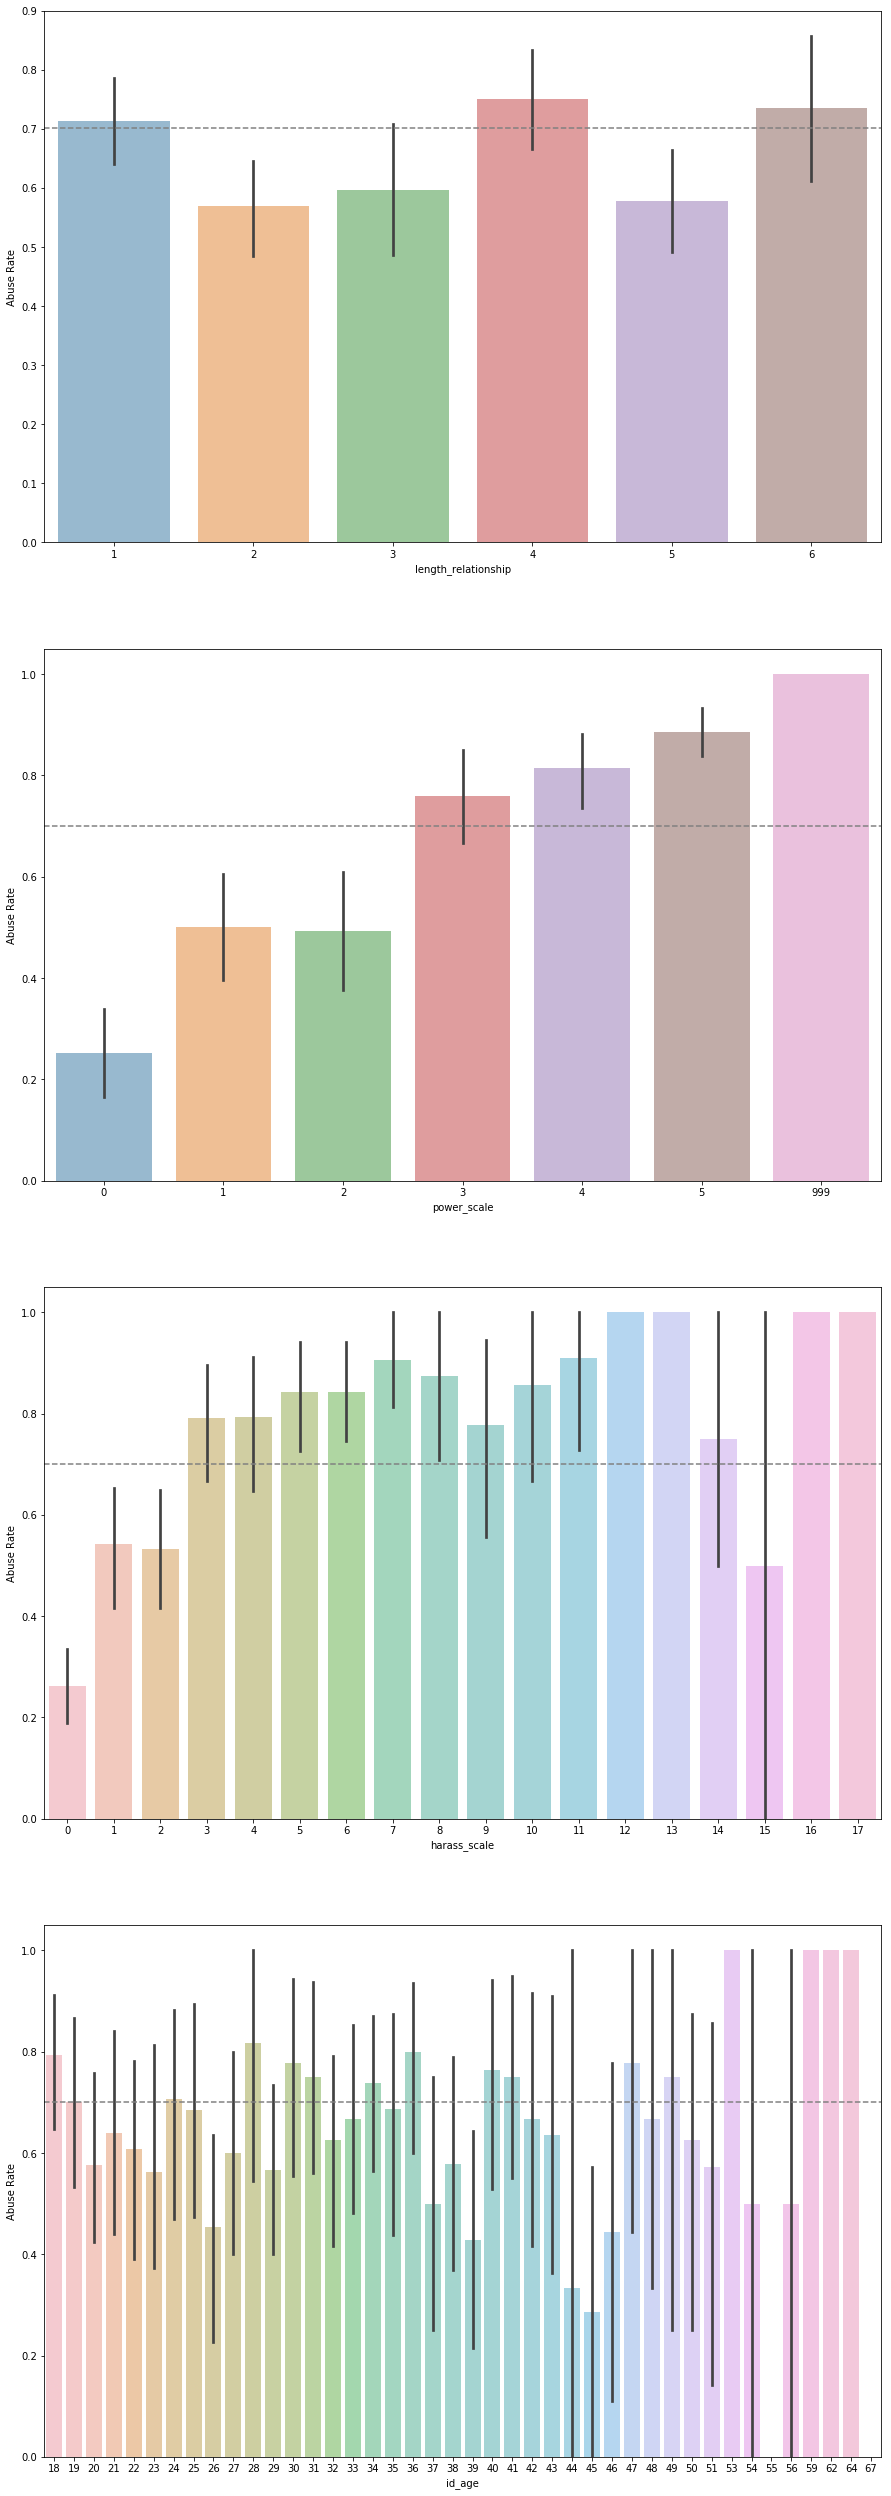

In [27]:
_, ax = plt.subplots(nrows=4, ncols=1, figsize=(15, 45))

abuse_rate = train_df.abuse_past_year.mean()

for i, feature in enumerate(continuous_vars):
    sns.barplot(feature, 'abuse_status', data=train_df, ax=ax[i], alpha=.5)
    ax[i].set_ylabel('Abuse Rate')
    ax[i].axhline(abuse_rate, ls='--', color='grey')

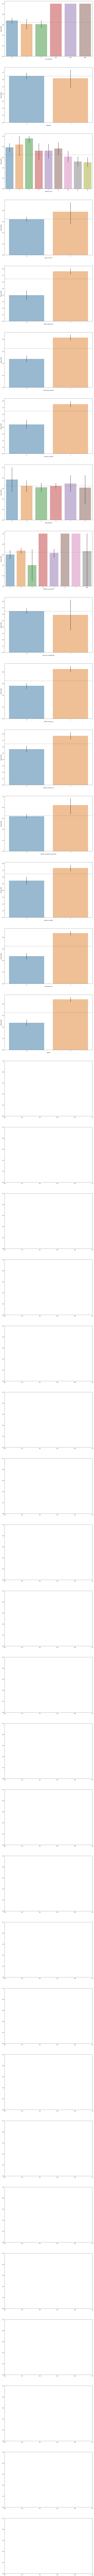

In [28]:
_, ax = plt.subplots(nrows=39, ncols=1, figsize=(15, 450))

abuse_rate = train_df.abuse_status.mean()

for i, feature in enumerate(keep):
    sns.barplot(feature, 'abuse_status', data=train_df, ax=ax[i], alpha=.5)
    ax[i].set_ylabel('Abuse Rate')
    ax[i].axhline(abuse_rate, ls='--', color='grey')

# Min/Max Scaling for the continuous variables.

In [29]:
scaler = MinMaxScaler()

scaler.fit(train_df[continuous_vars])

train_df[continuous_vars] = scaler.transform(train_df[continuous_vars])
test_df[continuous_vars] = scaler.transform(test_df[continuous_vars])

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/usr/local/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pyda

# EVEN MORE EXPLORATORY DATA ANALYSIS (EDA) OF DF (GENERAL SAMPLE INCLUDING AW & NAW)

In [30]:
def missing_values_col(df):
    """
    Thids function returns the total missing values
    and the percent missing values by column.
    """
    null_count = df.isnull().sum()
    null_percentage = (null_count / df.shape[0]) * 100
    empty_count = pd.Series(((df == ' ') | (df == '')).sum())
    empty_percentage = (empty_count / df.shape[0]) * 100
    nan_count = pd.Series(((df == 'nan') | (df == 'NaN')).sum())
    nan_percentage = (nan_count / df.shape[0]) * 100
    return pd.DataFrame({'num_missing': null_count, 'missing_percentage': null_percentage,
                         'num_empty': empty_count, 'empty_percentage': empty_percentage,
                         'nan_count': nan_count, 'nan_percentage': nan_percentage})


def missing_values_row(df):
    """
    Write or use a previously written function to return the
    total missing values and the percent missing values by row.
    """
    null_count = df.isnull().sum(axis=1)
    null_percentage = (null_count / df.shape[1]) * 100
    return pd.DataFrame({'num_missing': null_count, 'percentage': null_percentage})


def handle_missing_threshold(df, prop_required_column = .3, prop_required_row = .9):
    """
    Removes columns and rows whose count of missing values exceeds threshold.
    """
    threshold = int(round(prop_required_column*len(df.index),0))
    df.dropna(axis=1, thresh=threshold, inplace=True)
    threshold = int(round(prop_required_row*len(df.columns),0))
    df.dropna(axis=0, thresh=threshold, inplace=True)
    return df


def count_values(column):
    return df[column].value_counts(dropna=False)

def summarize_data(df):
    
    df_head = df.head()
    print(f'HEAD\n{df_head}', end='\n\n')
   
    df_tail = df.tail()
    print(f'TAIL\n{df_tail}', end='\n\n')

    shape_tuple = df.shape
    print(f'SHAPE: {shape_tuple}', end='\n\n')
    
    df_describe = df.describe()
    print(f'DESCRIPTION\n{df_describe}', end='\n\n')
    
    df.info()
    print(f'INFORMATION')    

    print(f'VALUE COUNTS', end='\n\n')
    for col in df.columns:
        n = df[col].unique().shape[0]
        col_bins = min(n, 10)
        print(f'{col}:')
        if df[col].dtype in ['int64', 'float64'] and n > 10:
            print(df[col].value_counts(bins=col_bins, sort=False, dropna=False))
        else:
            print(df[col].value_counts(dropna=False))
        print('\n')


def plot_hist(df):
    """
    Plots the distribution of the dataframe's variables.
    """
    df.hist(figsize=(24, 20), bins=20)

In [31]:
missing_values_col(df)

,num_missing,missing_percentage,num_empty,empty_percentage,nan_count,nan_percentage
id,0,0.0,0,0.0,0,0.0
abuse_past_year,0,0.0,0,0.0,0,0.0
abuse_status,0,0.0,0,0.0,0,0.0
length_relationship,0,0.0,0,0.0,0,0.0
partner_abusive,0,0.0,0,0.0,0,0.0
num_abusers,0,0.0,0,0.0,0,0.0
num_children,0,0.0,0,0.0,0,0.0
pregnant,0,0.0,0,0.0,0,0.0
beaten_while_pregnant,0,0.0,0,0.0,0,0.0
support_score,0,0.0,0,0.0,0,0.0


In [32]:
missing_values_row(df)

,num_missing,percentage
0,0,0.0
1,0,0.0
2,0,0.0
3,0,0.0
4,0,0.0
5,0,0.0
6,0,0.0
7,0,0.0
8,0,0.0
9,0,0.0


In [33]:
summarize_data(df)

HEAD
       id  abuse_past_year  abuse_status  length_relationship  \
0  108395                1             1                    1   
1  108397                1             1                    2   
2  108399                1             1                    5   
3  108443                1             1                    2   
4  108444                1             1                    2   

   partner_abusive  num_abusers  num_children  pregnant  \
0                1            1             1         0   
1                1            1             0         0   
2                1            1             2         0   
3                1            1             0         1   
4                1            1             1         0   

   beaten_while_pregnant  support_score    ...      partner_arrested  \
0                      0              0    ...                     0   
1                      0             11    ...                     1   
2                      0         

limit_family_contact:
0    368
1    337
Name: limit_family_contact, dtype: int64


location_tracking:
1    463
0    242
Name: location_tracking, dtype: int64


threat_hit:
1    375
0    330
Name: threat_hit, dtype: int64


thrown_object:
0    469
1    236
Name: thrown_object, dtype: int64


push_shove:
1    437
0    268
Name: push_shove, dtype: int64


slap:
0    377
1    328
Name: slap, dtype: int64


kick_punch:
0    425
1    280
Name: kick_punch, dtype: int64


hit_object:
0    527
1    178
Name: hit_object, dtype: int64


beaten:
0    483
1    222
Name: beaten, dtype: int64


choked:
0    473
1    232
Name: choked, dtype: int64


threat_knife:
0    593
1    112
Name: threat_knife, dtype: int64


threat_gun:
0    636
1     69
Name: threat_gun, dtype: int64


rape_with_threat:
0    530
1    175
Name: rape_with_threat, dtype: int64


power_scale:
5      175
0      120
4      116
3      107
1      101
2       83
999      3
Name: power_scale, dtype: int64


harass_scale:
(-0.01800000000

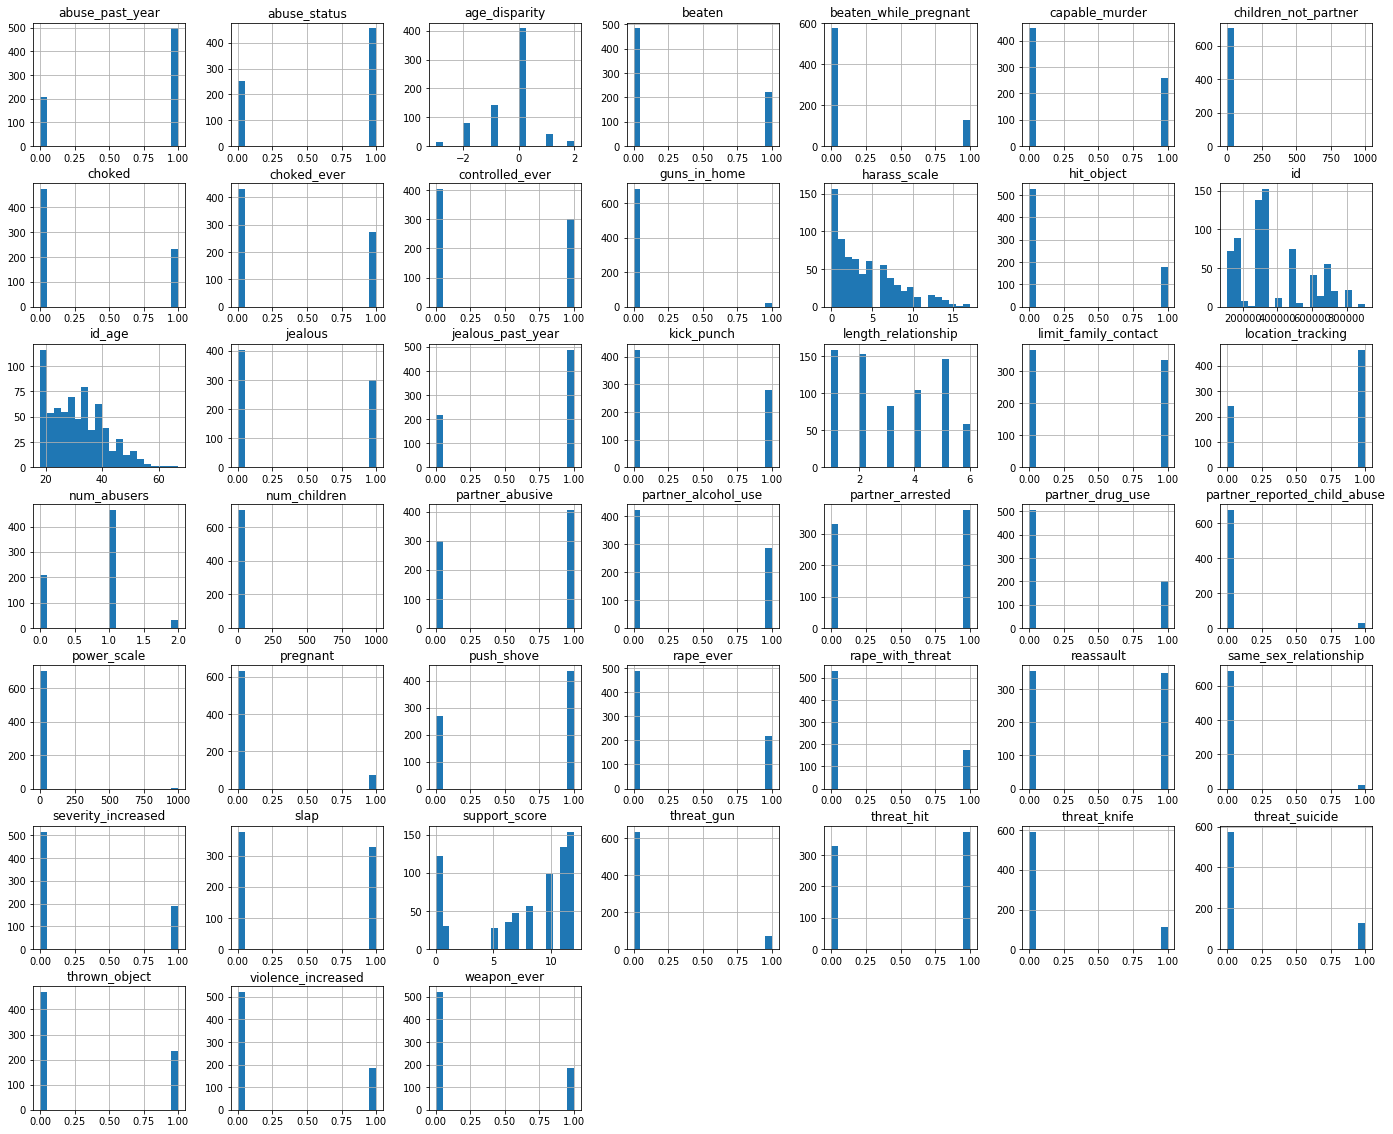

In [34]:
plot_hist(df)

In [35]:
df.head()

,id,abuse_past_year,abuse_status,length_relationship,partner_abusive,num_abusers,num_children,pregnant,beaten_while_pregnant,support_score,...,partner_arrested,violence_increased,severity_increased,weapon_ever,choked_ever,rape_ever,controlled_ever,jealous,capable_murder,reassault
0,108395,1,1,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,108397,1,1,2,1,1,0,0,0,11,...,1,0,1,1,1,1,0,1,1,1
2,108399,1,1,5,1,1,2,0,0,0,...,0,0,0,0,1,0,0,0,0,1
3,108443,1,1,2,1,1,0,1,0,12,...,1,0,0,1,1,0,1,0,0,0
4,108444,1,1,2,1,1,1,0,0,11,...,1,1,1,0,0,0,0,0,0,1


In [36]:
df.shape

(705, 45)

In [37]:
df.columns

Index(['id', 'abuse_past_year', 'abuse_status', 'length_relationship',
       'partner_abusive', 'num_abusers', 'num_children', 'pregnant',
       'beaten_while_pregnant', 'support_score', 'guns_in_home',
       'jealous_past_year', 'limit_family_contact', 'location_tracking',
       'threat_hit', 'thrown_object', 'push_shove', 'slap', 'kick_punch',
       'hit_object', 'beaten', 'choked', 'threat_knife', 'threat_gun',
       'rape_with_threat', 'power_scale', 'harass_scale', 'id_age',
       'age_disparity', 'children_not_partner', 'same_sex_relationship',
       'partner_drug_use', 'partner_alcohol_use', 'threat_suicide',
       'partner_reported_child_abuse', 'partner_arrested',
       'violence_increased', 'severity_increased', 'weapon_ever',
       'choked_ever', 'rape_ever', 'controlled_ever', 'jealous',
       'capable_murder', 'reassault'],
      dtype='object')

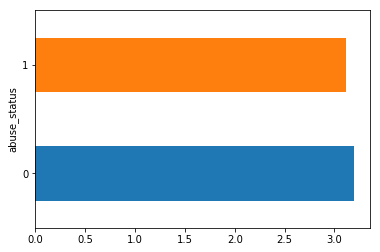

In [38]:
df.groupby('abuse_status')['length_relationship'].mean().plot.barh()

## The average length of the relationship is not so different for the AW and NAW groups.

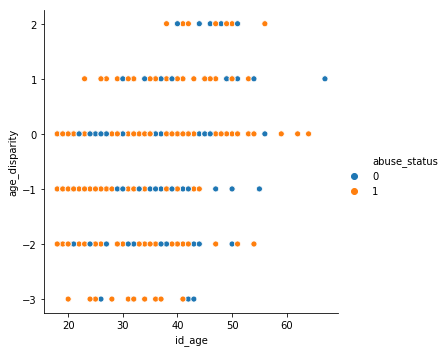

In [39]:
sns.relplot(x='id_age', y='age_disparity', data=df, hue='abuse_status')

# t-Distributed Stochastic Neighbor Embedding (t-SNE)

In [40]:
from sklearn.decomposition import TruncatedSVD
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
%matplotlib inline

import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2.5})
RS = 123

# We want to eliminate the violent features, so we drop columns from the dfa and only select features that are not about extremely violent acts/info.

In [41]:
keep = list(dfa.drop(columns={'id','abuse_past_year', 'abuse_status','partner_abusive', 'num_abusers','beaten_while_pregnant','threat_hit', 'thrown_object', 'push_shove', 'slap', 'kick_punch',
       'hit_object', 'beaten', 'choked', 'threat_knife', 'threat_gun','rape_with_threat','harass_scale','threat_suicide','violence_increased', 'severity_increased', 'weapon_ever',
       'choked_ever', 'rape_ever','capable_murder'}).columns)

In [42]:
keep

['length_relationship',
 'num_children',
 'pregnant',
 'support_score',
 'guns_in_home',
 'jealous_past_year',
 'limit_family_contact',
 'location_tracking',
 'power_scale',
 'id_age',
 'age_disparity',
 'children_not_partner',
 'same_sex_relationship',
 'partner_drug_use',
 'partner_alcohol_use',
 'partner_reported_child_abuse',
 'partner_arrested',
 'controlled_ever',
 'jealous',
 'reassault']

# Split Train/Test for the t-SNE and PCA

In [43]:
x_columns = keep
X = dfa[x_columns]
y = dfa[['abuse_past_year']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .20, random_state = 0, stratify=y)

train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

In [44]:
X_train.shape

(564, 20)

# This is the t-SNE.

In [45]:
time_start = time.time()

fashion_tsne = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=250, method='exact')
tsne_results = fashion_tsne.fit_transform(X_train)

print(('t-SNE done! Time elapsed: {} seconds').format(time.time()-time_start))

[t-SNE] Computing pairwise distances...
[t-SNE] Computed conditional probabilities for sample 564 / 564
[t-SNE] Mean sigma: 2.582078
[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.604156
[t-SNE] Error after 251 iterations: 179769313486231570814527423731704356798070567525844996598917476803157260780028538760589558632766878171540458953514382464234321326889464182768467546703537516986049910576551282076245490090389328944075868508455133942304583236903222948165808559332123348274797826204144723168738177180919299881250404026184124858368.000000
t-SNE done! Time elapsed: 5.394588232040405 seconds


In [46]:
y_train

,abuse_past_year
28,1
343,0
525,1
612,1
324,0
166,0
327,0
169,1
74,1
263,1


# Set some colors for the labels.

In [47]:
# Label to color dict (manual)
label_color_dict = {1:'Abuse',0:'Not Abuse'}

# Color vector creation
cvec = [label_color_dict[label] for label in y_train.abuse_past_year]

### For t-SNE and PCA, refer to this article for some basic info: https://www.datacamp.com/community/tutorials/introduction-t-sne

# Plot t-SNE

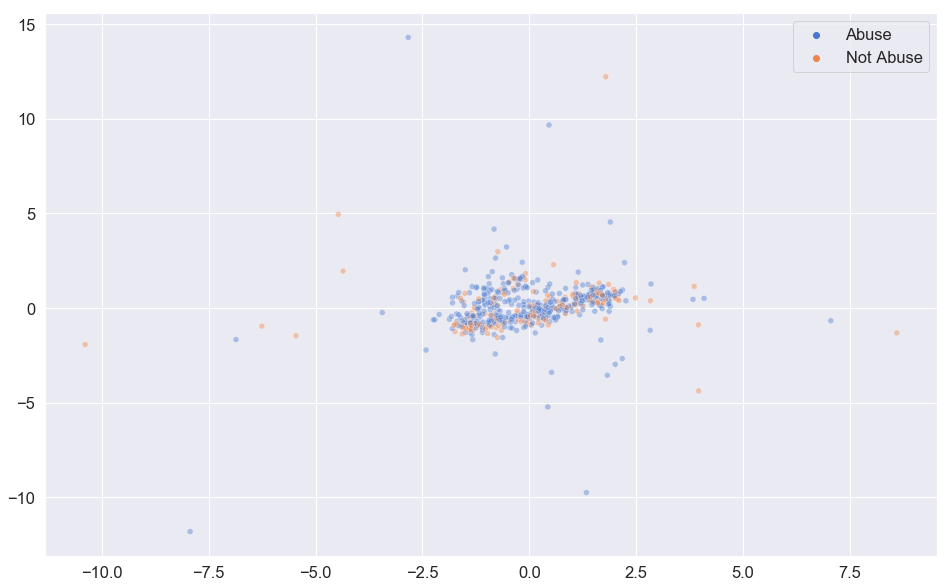

In [48]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=tsne_results[:,0], y=tsne_results[:,1],
    hue=cvec,
    data=X_train,
    legend="full",
    alpha=0.4
)

# This is the (Principal Component Analysis) PCA.

In [49]:
from sklearn.decomposition import PCA

In [50]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(X_train.values)
pca_df = pd.DataFrame()
pca_df['pca-one'] = pca_result[:,0]
pca_df['pca-two'] = pca_result[:,1] 
pca_df['pca-three'] = pca_result[:,2]

print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.64957196 0.33631057 0.01057929]


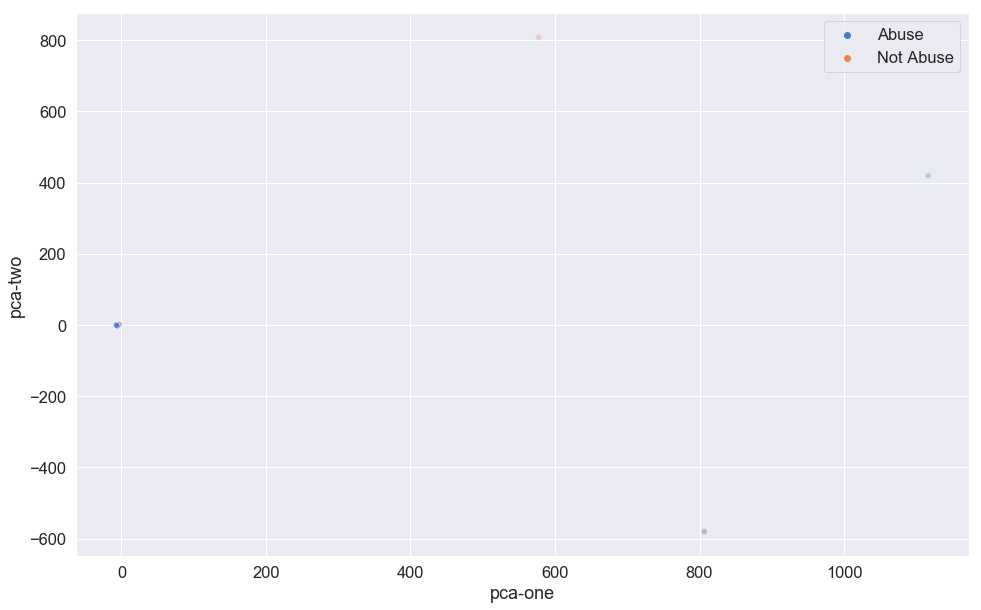

In [51]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=pca_df['pca-one'], y=pca_df['pca-two'],
    hue=cvec,
    data=X_train,
    legend="full",
    alpha=0.3
)

In [52]:
df[df.reassault == 1].shape

(350, 45)

## _So now we can see the cases where reassault happened. There are 350 cases out of 705. There were 497 cases of domestic violence._

In [53]:
df.choked.value_counts()

0    473
1    232
Name: choked, dtype: int64

In [54]:
df[df.choked == 1].shape

(232, 45)

In [55]:
df.abuse_past_year.value_counts()

1    497
0    208
Name: abuse_past_year, dtype: int64

In [56]:
df.loc[(df['abuse_past_year'] >= 1) & (df['choked'] <= 1)].shape

(497, 45)

## _232 cases involved choking or strangulation in the past year._

In [57]:
df.choked_ever.value_counts()

0    430
1    275
Name: choked_ever, dtype: int64

In [58]:
df[df.choked_ever == 1].shape

(275, 45)

In [59]:
df.loc[(df['abuse_past_year'] >= 1) & (df['choked_ever'] <= 1)].shape

(497, 45)

## _275 cases involved choking or strangulation at least once._

In [60]:
df.weapon_ever.value_counts()

0    520
1    185
Name: weapon_ever, dtype: int64

In [61]:
df[df.weapon_ever == 1].shape

(185, 45)

## _185 cases involved a weapon at least once._

In [62]:
df.violence_increased.value_counts()

0    520
1    185
Name: violence_increased, dtype: int64

In [63]:
df.loc[(df['abuse_past_year'] >= 1) & (df['violence_increased'] <= 1)].shape

(497, 45)

In [64]:
df.severity_increased.value_counts()

0    516
1    189
Name: severity_increased, dtype: int64

In [65]:
df.loc[(df['abuse_past_year'] >= 1) & (df['severity_increased'] <= 1)].shape

(497, 45)

# Modeling

# Naive Bayes

In [66]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [67]:
X = df[keep]
y = df[['abuse_past_year']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .15, random_state = 0, stratify=y)

train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

In [68]:
gnb = GaussianNB()


In [69]:
gnb.fit(X_train, y_train)


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GaussianNB(priors=None)

In [70]:
y_pred = gnb.predict(X_train)

In [71]:
y_pred_proba = gnb.predict_proba(X_train)

In [72]:
print('Accuracy of GNB classifier on training set: {:.2f}'
     .format(gnb.score(X_train, y_train)))

Accuracy of GNB classifier on training set: 0.91


In [73]:
print(confusion_matrix(y_train, y_pred))


[[170   7]
 [ 49 373]]


In [74]:
print(classification_report(y_train, y_pred))


             precision    recall  f1-score   support

          0       0.78      0.96      0.86       177
          1       0.98      0.88      0.93       422

avg / total       0.92      0.91      0.91       599



# This Gaussian Naive Bayes Model performed well at 91% accuracy with the following features:

In [75]:
keep

['length_relationship',
 'num_children',
 'pregnant',
 'support_score',
 'guns_in_home',
 'jealous_past_year',
 'limit_family_contact',
 'location_tracking',
 'power_scale',
 'id_age',
 'age_disparity',
 'children_not_partner',
 'same_sex_relationship',
 'partner_drug_use',
 'partner_alcohol_use',
 'partner_reported_child_abuse',
 'partner_arrested',
 'controlled_ever',
 'jealous',
 'reassault']

## Try another GNB model with a lot fewer features. These are the top 5 features of significance according to the chi squared testing.

In [76]:
top5 = ['threat_hit',
             'controlled_ever',
             'jealous',
             'location_tracking',
             'thrown_object'
            ]

In [77]:
X = df[top5]
y = df[['abuse_past_year']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .15, random_state = 0, stratify=y)

train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

In [78]:
gnb = GaussianNB()

In [79]:
gnb.fit(X_train, y_train)

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GaussianNB(priors=None)

In [80]:
y_pred = gnb.predict(X_train)

In [81]:
y_pred_proba = gnb.predict_proba(X_train)

In [82]:
print('Accuracy of GNB classifier on training set: {:.2f}'
     .format(gnb.score(X_train, y_train)))

print(confusion_matrix(y_train, y_pred))


print(classification_report(y_train, y_pred))

Accuracy of GNB classifier on training set: 0.93
[[174   3]
 [ 38 384]]
             precision    recall  f1-score   support

          0       0.82      0.98      0.89       177
          1       0.99      0.91      0.95       422

avg / total       0.94      0.93      0.93       599



# The GNB model performs better with the top 5 features. It has accuracy of 93%.

# Linear Support Vector Machine Model

In [103]:
from sklearn.linear_model import SGDClassifier

In [104]:
X = df[top5]
y = df[['abuse_past_year']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .15, random_state = 0, stratify=y)

train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

In [105]:
sgd = SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)

In [106]:
sgd.fit(X_train, y_train)

y_pred = sgd.predict(X_train)

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [110]:
print('accuracy %s' % sgd.score(y_pred, y_train))
#print(classification_report(y_train, y_pred, target_names=my_tags))

ValueError: Expected 2D array, got 1D array instead:
array=[0 0 0 1 0 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 0 0 1 0 0 0 1 1 0 0 0 1 1 1 1 1
 1 0 0 1 0 0 1 1 0 1 0 1 0 1 1 0 1 1 0 0 1 1 1 1 0 1 0 0 1 0 0 0 1 0 1 0 1
 1 1 1 1 1 1 1 1 0 1 1 1 0 0 1 0 0 1 0 1 0 1 0 1 1 1 0 1 0 1 1 1 1 1 0 1 1
 1 1 0 1 1 0 1 0 0 1 1 1 0 0 1 1 1 1 1 0 1 1 0 0 1 0 1 1 0 1 1 0 1 1 1 1 1
 0 0 0 0 1 0 1 0 1 1 1 0 0 1 1 0 0 0 0 1 0 1 1 0 1 1 1 1 1 0 1 1 0 1 1 1 1
 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 0 0 1 0
 0 1 0 1 1 1 1 1 1 0 1 0 1 1 1 0 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1
 1 1 1 1 1 0 1 1 1 1 1 0 1 0 0 1 1 1 1 0 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1
 1 1 0 0 0 0 1 1 1 0 1 1 0 1 0 1 1 1 0 1 1 0 1 0 1 0 1 1 0 1 1 1 0 1 1 1 1
 1 1 1 0 1 0 1 1 0 0 1 1 0 1 1 1 0 1 1 0 1 1 0 1 1 1 1 1 1 0 0 0 0 1 0 1 0
 1 1 0 0 1 1 1 0 0 1 1 1 0 1 0 1 1 1 1 1 0 1 0 1 0 1 1 1 0 1 1 0 1 1 1 0 1
 1 1 0 0 0 1 0 0 1 0 1 1 1 1 1 0 0 1 1 0 0 0 1 1 0 0 0 0 0 1 0 0 1 1 1 1 0
 0 0 1 1 1 1 0 0 1 0 1 0 1 0 1 1 1 1 0 1 0 0 1 1 1 1 1 1 1 0 0 1 0 1 1 1 1
 0 0 1 0 1 0 1 1 1 1 0 0 0 0 0 1 1 1 1 0 1 1 1 1 1 1 1 1 0 0 1 0 1 1 0 1 0
 1 0 1 1 1 0 0 0 0 1 1 1 0 1 1 0 1 1 1 1 1 1 0 1 1 0 0 1 0 1 0 1 1 0 1 1 1
 1 0 0 0 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 0 0 1 0 0 0 1 1 0 0 1 0 0 1 0 0 1 0
 1 1 1 1 1 1 1].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

# PHASE 2

# -~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-

# Taking a peek at the other data that we have... 

# Dataframes 6 & 11 contain information on AW (Abused Woman) cases.

In [87]:
df6 = acquire.read_data('data06.csv')
# df8 = acquire.read_data('data08.csv') # NO USEFUL COLUMNS
df11 = acquire.read_data('data11.csv')
# df12 = acquire.read_data('data12.csv') # NO USEFUL COLUMNS

In [88]:
print(df6.head())
# print(df8.head())
print(df11.head())
# print(df12.head())

   CASEID  INVIEWN  ABUSED  SAMESEXR  RACER  M4GUN  M5FIRED  M6MSCRRG  \
0  108395        1       1      9999      1      2     9999         2   
1  108397        1       1      9999      9      2     9999         2   
2  108399        1       1      9999      1      2     9999         2   
3  108443        1       1      9999      1      2     9999         2   
4  108444        1       1      9999      1      2     9999         2   

   M7TIEDUP  M8PRSNT    ...     M40CNSL3  M40CNSL4  M44ADV1  M44ADV2  M44ADV3  \
0         2        2    ...         9999      9999        1     9999     9999   
1         2        1    ...         9999      9999        1     9999     9999   
2         1        1    ...         9999      9999        2        1     9999   
3         2        1    ...         9999      9999       26     9999     9999   
4         2        1    ...         9999      9999        1     9999     9999   

   M22NOINJ  M22NONED  M22PRIV  M22EMBAR  HELPTYPE  
0         1         0

In [89]:
# Specify columns to take from dataframes 6, 8, 11, and 12:


six_cols = ['CASEID',
            'M5FIRED',
            'M11HIGH',
            'M35SAFE',
            'M41ILLGL',
            'M42DAGRR',
            'M13TALKR',
            'M32OTHER',
            'M27HOW',
            'M30ARRES',
            'M31HOW',
            'M38ORDER',
           ]

eleven_cols = ['CASEID',
               'SEVERER',
               'TOTINCR',
               'THREATR',
               'SLAPR',
               'PUNCHR',
               'BEATR',
               'UWEAPON',
               'FORCEDR',
               'MISCARR',
               'RESTRAIN',
               'CHOKED',
               'NDRUNK',
               'RDRUNK',
               'BOTHDRUN',
               'NDRUGS',
               'RDRUGS',
               'BOTHDRUG',
              ]


In [90]:
# drop dataframes down to desired features
df6 = df6[six_cols]
df11 = df11[eleven_cols]

In [91]:
print(df6.shape)
print(df11.shape)

(497, 12)
(497, 18)


In [92]:
dfb = df6.merge(right=df11, on='CASEID')

## dfb: this is the dataframe with the AW (Abused Woman) cases 

In [93]:
# df9 & 10 are cases of AW (Abused Woman)
df9 = acquire.read_data('data09.csv')
df10 = acquire.read_data('data10.csv')

# df 13, 14 & 15 are cases of HOMICIDE
df13 = acquire.read_data('data13.csv')
df14 = acquire.read_data('data14.csv')
df15 = acquire.read_data('data15.csv')

In [94]:
df10.head()

,CASEID,INVIEWN,IDINCID,INCIDENT,FORCED,YEAR,MONTH,DAY,DATECERT,USOBJ,...,NDRUGS,BOTHDRUG,SUBSTANC,SEVEREST,TOINC,INTYEAR,INTMONTH,INTDAY,DAYSTOIN,DATECOM
0,108395,1,108395000,2,0,1997,12,15,2,2,...,0,0,1,2,1,1998,1,27,43,1
1,108397,1,108397000,1,0,1997,6,28,2,2,...,0,0,2,4,2,1998,1,27,213,1
2,108397,1,108397000,4,0,1998,1,20,2,1,...,0,0,2,4,999,1998,1,27,7,1
3,108399,1,108399000,1,0,1998,1,3,2,2,...,0,0,1,3,2,1998,1,30,27,1
4,108399,1,108399000,3,0,1998,1,27,2,2,...,0,0,1,3,999,1998,1,30,3,1


# Examine dfb in more detail. Take information from df10 and create a column that shows which cases had repeat offenses.

In [95]:
dfb.head()

,CASEID,M5FIRED,M11HIGH,M35SAFE,M41ILLGL,M42DAGRR,M13TALKR,M32OTHER,M27HOW,M30ARRES,...,FORCEDR,MISCARR,RESTRAIN,CHOKED,NDRUNK,RDRUNK,BOTHDRUN,NDRUGS,RDRUGS,BOTHDRUG
0,108395,9999,2,1,2,0,1,99,99999,3,...,0,0,0,0,0,0,0,0,0,0
1,108397,9999,2,1,2,0,1,99,99999,3,...,0,0,0,1,2,0,0,0,0,0
2,108399,9999,2,1,2,0,1,99,99999,3,...,0,0,1,1,0,0,0,0,0,0
3,108443,9999,2,1,2,0,1,13,99999,3,...,0,0,0,1,1,0,0,0,0,0
4,108444,9999,1,1,2,0,1,99,99999,3,...,0,0,0,0,3,0,0,0,0,0


# This new column, RECID, is a boolean value that tells us whether the cases were re-assault cases or not.

# So now we can see the cases where recidivism happened. There are 350 cases out of 705. There were 497 cases of domestic violence.

In [96]:
dfb[dfb.RECID == 1]

AttributeError: 'DataFrame' object has no attribute 'RECID'

In [ ]:
df13

In [ ]:
df14

In [ ]:
df15

In [ ]:
df11